# RedDots Dataset release r2015q4_v1

RedDots dataset can be downloaded for free [here](https://sites.google.com/site/thereddotsproject/reddots-challenge).

It's target was to get 52 sessions per speaker, 24 sentences for each session: 10 common for all speakers, 10 unique to each speaker, 2 sentences of free choice, 2 free text.

It has 62 speakers including 49 male speakers and 13 female speakers from 21 countries. The total number of sessions for the current release is 572 (473 male and 99 female sessions). There are 15306 recordings.

## File / path format (mainly interesting for reading the data)

### /pcm folder contains .pcm files with recordings

Recordings have format
`pcm/{speaker}/{recording}.pcm`
where
`{speaker} = {gender}{speaker_id}`
`{recording} = {speaker}/{timestamp}_{speaker}_{sentence}`

They simply contain uncompressed sequences of samples. The values are signed int16 and the frequency of samples is 16kHz. 

### /ndx contains definitions of test sets

There are 4 proposed trials based on the gathered recordings. They use common, unique, free-choice and text-prompted sentence recordings respectively.

#### .trn - train set, enrollments
`{speaker}_{sentence} {recording},{recording},{recording}`
(the fourth test set has 4 recordings per enrollment)

eg. `m0001_31 m0001/20150130084154554_m0001_31,m0001/20150130084155412_m0001_31,m0001/20150130084156114_m0001_31`

#### .ndx - test set, trials

`{speaker}_{sentence},{recording},{target correct},{target wrong},{imposter correct},{imposter wrong}`

eg. `m0001_31,m0001/20150129213253016_m0001_36,N,Y,N,N`

The N, Y sequence means in order:

* target - same person
* imposter - different person
* correct - same sentence
* wrong - different sentence

There is some redundancy in those values. Only one of them can be set to 'Y' for a sample. Moreover, `target = Y` means that the speaker identifier on the left (in the `{speaker}_{sentence}` part) is same as the on right (in the `{recording}` part), while `imposter = Y` means they are different. Similarly, when `correct = Y` the sentence number on the left is equal to the number on the right and when `wrong = Y` they are different.

#### Parts

* Part 01: Common Pass-phrases Text-Dependent. All speakers say sentences with ids 31-40, which come from TIMIT. Train set contains of recordings where a person (with exception of several people excluded to be 'imposters') says one of the ten sentences. All combinations are covered three times, with three sessions. Test set uses a different recordings.
* Part 02: Unique Pass-phrases Text-Dependent. Unique to each speaker, same across sessions, assigned to speakers by the dataset creator. The difference is that since each speaker has a different set of sentences, there is no case of an impostor saying a correct sentence.
* Part 03: Free-choice Pass-phrases Text-Dependent. Unique to each speaker, same across session, chosen by the recorded people. Like in part 02 there are no cases of an impostor saying a correct sentence. The difference is that the sentences are chosen by the enrolling people, so they could be too short or not cover many phonemes.
* Part 04: Text-Prompted. Unique across sessions, excerpts from Wikipedia. It consists of two subparts: 
 * tp - text prompted/independent, there are six text-prompted recordings per person in the training set. Recordings with same content are not present in the test set.
 * td - text dependent. Train set consist of recordings from parts 1-3. Test set has recordings from parts 1-3 and also text-prompted recordings.
 
Sessions 2, 4, 6 are used for enrollment, except for text-prompted case where sessions 1, 2, 3, 4, 6 are used.

Test sets in .ndx are very large, because they contain all possible pairs of test `{speaker}_{sentence}` and test recordings. 

Test sets contain both previously registered people and impostors that are not enrolled.


In [1]:
import functools as ft
import itertools as it
import json
import math
import operator as op
import os
import re

from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import misc, signal
from sklearn import metrics

with open('paths.json') as opened:
    paths = json.load(opened)
print(paths)
reddots_root = paths['reddots_root']

{'reddots_root': '../input/reddots_r2015q4_v1'}


In [2]:
def read_files(*paths, encoding='utf-8'):
    for path in paths:
        with open(path, encoding=encoding) as opened:
            yield from opened


recording_regex = re.compile(r'([mf])(\d+)/(\d+)_[mf]\d+_(\d+)')
def parse_recording(value):
    match = recording_regex.match(value)
    if match:
        return match.groups()

print(parse_recording('m0001/20150129213253016_m0001_36'))


speaker_sentence_regex = re.compile(r'([mf])(\d+)_(\d+)')
def parse_speaker_sentence(value):
    match = speaker_sentence_regex.match(value)
    if match:
        return match.groups()
    
print(parse_speaker_sentence('m0001_31'))


timestamp_format='%Y%m%d%H%M%S%f'
def parse_timestamp(timestamp):
    return pd.to_datetime(timestamp, format=timestamp_format)

print(parse_timestamp('20150129213253016'))


def parse_gender(flag):
    return flag == 'm'

def parse_flag(flag):
    return flag == 'Y'


def load_trials(*paths):
    columns = ([], [], [], [], [], [], [], [], [], [])
    
    for line in read_files(*paths):
        speaker_sentence, recording, tc, tw, ic, iw = line.strip().split(',')
        
        expected_gender, expected_speaker_id, expected_sentence_id = parse_speaker_sentence(speaker_sentence)
        trial_gender, trial_speaker_id, trial_timestamp, trial_sentence_id = parse_recording(recording)
        
        expected_is_male = parse_gender(expected_gender)
        trial_is_male = parse_gender(trial_gender)
        
        target_person = parse_flag(tc) or parse_flag(tw)
        correct_sentence = parse_flag(tc) or parse_flag(ic)
        
        trial_timestamp = parse_timestamp(trial_timestamp)
        pcm_path = recording + '.pcm'
        
        record = (expected_is_male, expected_speaker_id, expected_sentence_id, 
                  trial_is_male, trial_speaker_id, trial_timestamp, trial_sentence_id,
                  pcm_path, target_person, correct_sentence)
        
        for value, column in zip(record, columns):
            column.append(value)
        
    data = {'expected_is_male':     pd.Series(columns[0], dtype=np.bool), 
            'expected_speaker_id':  pd.Series(columns[1], dtype=np.int16), 
            'expected_sentence_id': pd.Series(columns[2], dtype=np.int16), 
            'trial_is_male':        pd.Series(columns[3], dtype=np.bool), 
            'trial_speaker_id':     pd.Series(columns[4], dtype=np.int16), 
            'trial_timestamp':      pd.Series(columns[5], dtype='datetime64[ns]'), 
            'trial_sentence_id':    pd.Series(columns[6], dtype=np.int16),
            'pcm_path':             pd.Series(columns[7], dtype=str), 
            'target_person':        pd.Series(columns[8], dtype=np.bool), 
            'correct_sentence':     pd.Series(columns[9], dtype=np.bool)}
    return pd.DataFrame.from_dict(data)
        

def load_enrollments(*paths):
    columns = ([], [], [], [], [])

    for line in read_files(*paths):
        speaker_sentence, recordings = line.strip().split(' ', 1)
        for recording in recordings.split(','):
            gender, speaker_id, timestamp, sentence_id = parse_recording(recording)
            
            is_male = parse_gender(gender)
            timestamp = parse_timestamp(timestamp)
            pcm_path = recording + '.pcm'
            
            record = (is_male, speaker_id, timestamp, sentence_id, pcm_path)

            for value, column in zip(record, columns):
                column.append(value)

    data = {'is_male':     pd.Series(columns[0], dtype=np.bool), 
            'speaker_id':  pd.Series(columns[1], dtype=np.int16), 
            'timestamp':   pd.Series(columns[2], dtype='datetime64[ns]'), 
            'sentence_id': pd.Series(columns[3], dtype=np.int16),
            'pcm_path':    pd.Series(columns[4], dtype=str)}
    return pd.DataFrame.from_dict(data)


def load_pcm(root, path):
    full_path = os.path.join(root, path)
    return np.fromfile(full_path, np.int16)

load_pcm = ft.partial(load_pcm, reddots_root + '/pcm')

('m', '0001', '20150129213253016', '36')
('m', '0001', '31')
2015-01-29 21:32:53.016000


In [60]:
trials_1 = load_trials(reddots_root + '/ndx/f_part_01.ndx',
                       reddots_root + '/ndx/m_part_01.ndx')

In [102]:
enrollments_1 = load_enrollments(reddots_root + '/ndx/f_part_01.trn', 
                                 reddots_root + '/ndx/m_part_01.trn')

In [62]:
print(trials_1.dtypes)
trials_1.describe(include='all')

correct_sentence                  bool
expected_is_male                  bool
expected_sentence_id             int16
expected_speaker_id              int16
pcm_path                        object
target_person                     bool
trial_is_male                     bool
trial_sentence_id                int16
trial_speaker_id                 int16
trial_timestamp         datetime64[ns]
dtype: object


,correct_sentence,expected_is_male,expected_sentence_id,expected_speaker_id,pcm_path,target_person,trial_is_male,trial_sentence_id,trial_speaker_id,trial_timestamp
count,1283856,1283856,1.283856e+06,1.283856e+06,1283856,1283856,1283856,1.283856e+06,1.283856e+06,1283856
unique,2,2,NaN,NaN,4726,2,2,NaN,NaN,4726
top,False,True,NaN,NaN,m0020/20150802232439669_m0020_38.pcm,False,True,NaN,NaN,2015-06-12 05:04:47.622000
freq,1155456,1233280,NaN,NaN,320,1245096,1233280,NaN,NaN,320
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-29 10:57:40.589000
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-08-17 10:02:04.104000
mean,NaN,NaN,3.549457e+01,2.533627e+01,NaN,NaN,NaN,3.547157e+01,2.298235e+01,NaN
std,NaN,NaN,2.870385e+00,1.751693e+01,NaN,NaN,NaN,2.862488e+00,1.867127e+01,NaN
min,NaN,NaN,3.100000e+01,1.000000e+00,NaN,NaN,NaN,3.100000e+01,1.000000e+00,NaN
25%,NaN,NaN,3.300000e+01,1.200000e+01,NaN,NaN,NaN,3.300000e+01,8.000000e+00,NaN


In [63]:
print(enrollments_1.dtypes)
enrollments_1.describe(include='all')

is_male                  bool
pcm_path               object
sentence_id             int16
speaker_id              int16
timestamp      datetime64[ns]
dtype: object


,is_male,pcm_path,sentence_id,speaker_id,timestamp
count,1134,1134,1134.000000,1134.000000,1134
unique,2,1134,NaN,NaN,1134
top,True,m0017/20150218225158037_m0017_37.pcm,NaN,NaN,2015-03-25 22:32:45.259000
freq,960,1,NaN,NaN,1
first,NaN,NaN,NaN,NaN,2015-01-29 10:56:01.404000
last,NaN,NaN,NaN,NaN,2015-06-25 17:57:29.928000
mean,NaN,NaN,35.478836,23.052910,NaN
std,NaN,NaN,2.866089,17.624424,NaN
min,NaN,NaN,31.000000,1.000000,NaN
25%,NaN,NaN,33.000000,7.000000,NaN


In [18]:
recording_nopath_regex = re.compile(r'(\d+)_([mf])(\d+)_(\d+)')
def parse_recording_nopath(value):
    match = recording_nopath_regex.match(value)
    if match:
        return match.groups()

print(parse_recording_nopath('20150129213253016_m0001_36'))


def load_script(path):
    sentence_ids_to_contents = {}
    
    for line in read_files(path, encoding='latin1'):
        recording_nopath, content = line.strip().split(';')
        _, _, _, sentence_id = parse_recording_nopath(recording_nopath)
        if sentence_id not in sentence_ids_to_contents:
            sentence_ids_to_contents[sentence_id] = content
            
    sentence_ids, contents = list(zip(*sentence_ids_to_contents.items()))
    
    data = {'sentence_id': pd.Series(sentence_ids, dtype=np.int16),
            'content':     pd.Series(contents, dtype=str)}
    return pd.DataFrame.from_dict(data)

('20150129213253016', 'm', '0001', '36')


In [19]:
script = load_script(reddots_root + '/infos/script.txt')

In [20]:
print(script.dtypes)
script.describe(include='all')

content        object
sentence_id     int16
dtype: object


,content,sentence_id
count,1706,1706.000000
unique,1706,NaN
top,I played with him for five years,NaN
freq,1,NaN
mean,NaN,9311.605510
std,NaN,7024.521836
min,NaN,31.000000
25%,NaN,587.250000
50%,NaN,12307.500000
75%,NaN,14537.750000


## Spectrogram

In [89]:
def display_spectrogram(data, rate, result_scaling=np.log1p, view_range=None,
                        xlabel='Time [sec]', ylabel='Frequency [Hz]', 
                        root=None, title=None, show=True, *args, **kwargs):
    if root is None:
        fig, root = plt.subplots()
    if title is not None:
        plt.title(title)
    frequencies, times, spectrogram = signal.spectrogram(data, rate, *args, **kwargs)
    
    if view_range is not None:
        freq_start = np.searchsorted(frequencies, view_range[0], 'left')
        freq_end = np.searchsorted(frequencies, view_range[1], 'right')
        frequencies = frequencies[freq_start:freq_end]
        spectrogram = spectrogram[freq_start:freq_end, :]
    scaled_spectrogram = result_scaling(spectrogram) if result_scaling else spectrogram
    root.pcolormesh(times, frequencies, scaled_spectrogram)
    root.set_xlabel(xlabel)
    root.set_ylabel(ylabel)
    
    if show:
        plt.show()

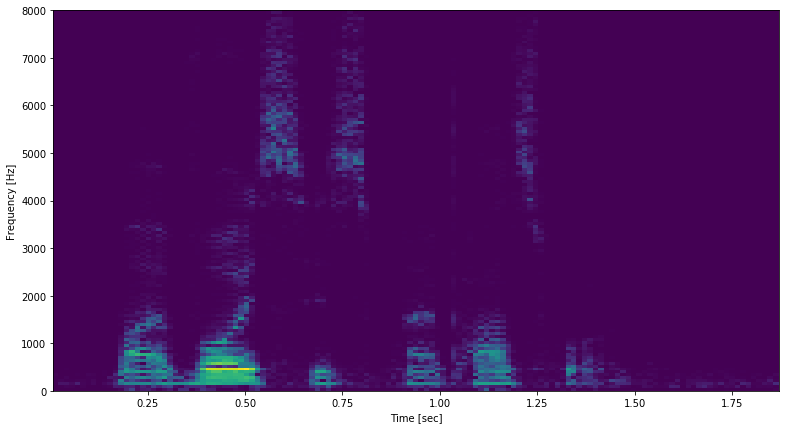

In [90]:
sample_sound = load_pcm(reddots_root + '/pcm', 'm0002/20150713085938321_m0002_31.pcm')

fig, ax = plt.subplots(1, 1, figsize=(13, 7))
display_spectrogram(sample_sound, 16000, root=ax)

# Unique people and sentences

In [104]:
people_ids = set(os.listdir(reddots_root + '/pcm'))

sentence_ids = set()
script_regex = re.compile(r'(\d+)_([mf]\d+)_(\d+);.*')
for line in read_files(reddots_root + '/infos/script.txt', encoding='latin1'):
    match = script_regex.match(line)
    sentence_id = match.group(3)
    sentence_ids.add(sentence_id)
    
print(len(people_ids), len(sentence_ids))

64 1706
